In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_auc_score, roc_curve
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display

In [2]:
N = 1_000_000
p0 = 0.95
offset = 0.15
p1 = 1 - p0
n0 = int(N * p0)
n1 = int(N - n0)

mu, sigma = 1, 0.1 # mean and standard deviation
x1 = np.random.normal(mu - offset/2, sigma, n0)
x2 = np.random.normal(mu + offset/2, sigma, n1)
df = pd.concat([pd.DataFrame({'value': x1, 'default': 0}), pd.DataFrame({'value': x2, 'default': 1})])
display(df.groupby('default', as_index=False, dropna=False).size())

,default,size
0,0,950000
1,1,50000


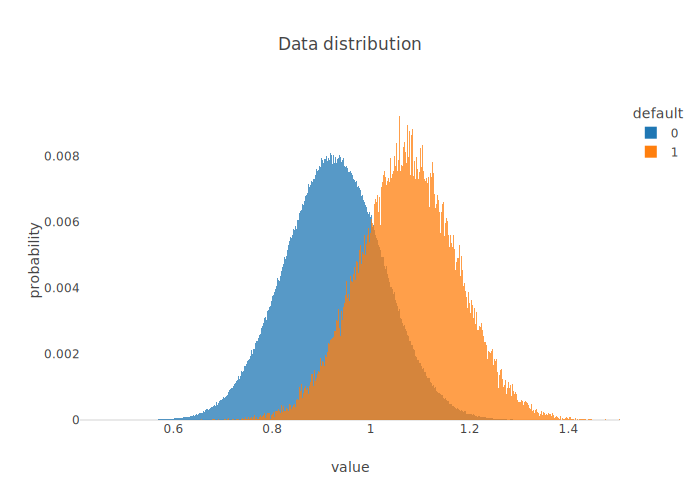

In [3]:
sqrt = int(np.sqrt(df.shape[0]))

fig = px.histogram(
  df
  , x="value"
  , color="default"
  , nbins=sqrt
  , histnorm="probability"
  , barmode="overlay"
  , title="Data distribution"
  , template='none'
)

fig.update_xaxes(showgrid=False, zeroline=False)
fig.update_yaxes(showgrid=False, zeroline=True, zerolinewidth=1, zerolinecolor='lightgray')

fig.show(renderer='svg')

In [4]:
model = LogisticRegression()
model.fit(df[['value']], df['default'])

intercept, coefficients = model.intercept_, model.coef_
print('intercept:', intercept[0])
print('coefficients:', coefficients[0])

probs = model.predict_proba(df[['value']])
df['probability_0'] = probs[:,0]
df['probability_1'] = probs[:,1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(df['default'], df['probability_1'])

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
gini = 2.0*roc_auc-1.0
print()
print(f'AUC: {roc_auc:.5f}')
print(f'Gini: {gini:.5f}')

intercept: -17.95899949910124
coefficients: [15.01123442]

AUC: 0.85688
Gini: 0.71375


In [5]:
N_bins = 1000

po0 = df['probability_1'].min()
po1 = df['probability_1'].max()
po_bins = np.histogram(df['probability_1'], bins=N_bins)[1]
np.append(po_bins, po0)
np.append(po_bins, po1)
po_bins = np.unique(po_bins)
po_bins = np.sort(po_bins)


sum_1 =  df['default'].sum()
sum_0 = df.shape[0] - sum_1
df_cp = df.copy()
dfs = []
for pbin in po_bins:
    df_cp['prediction_1'] = np.where(df_cp['probability_1'] > pbin, 1, -1)
    df_cp['TP'] = np.where(df_cp['default'] == df_cp['prediction_1'], 1, 0)
    df_cp['FP'] = np.where((df_cp['prediction_1'] == 1) & (df_cp['default'] == 0), 1, 0)
    
    TPR = df_cp['TP'].sum() / sum_1
    FPR = df_cp['FP'].sum() / sum_0

    pd_row = pd.DataFrame({'Threshold': [pbin], 'TPR': [TPR], 'FPR': [FPR]})
    dfs.append(pd_row)

roc_tab = pd.concat(dfs, ignore_index=True)
roc_tab = roc_tab.sort_values('Threshold')
display(roc_tab)

,Threshold,TPR,FPR
0,0.000008,1.00000,0.999999
1,0.000998,0.99962,0.970669
2,0.001988,0.99816,0.923636
3,0.002978,0.99582,0.876739
4,0.003968,0.99300,0.833397
...,...,...,...
996,0.986195,0.00002,0.000000
997,0.987185,0.00002,0.000000
998,0.988175,0.00002,0.000000
999,0.989165,0.00002,0.000000


In [6]:
roc_tab = roc_tab.sort_values('FPR', ascending=False)
roc_auc = -1 * np.trapz(roc_tab['TPR'], roc_tab['FPR'])
gini = 2.0*roc_auc-1.0

print(f'AUC: {roc_auc:.5f}')
print(f'Gini: {gini:.5f}')

AUC: 0.85687
Gini: 0.71374


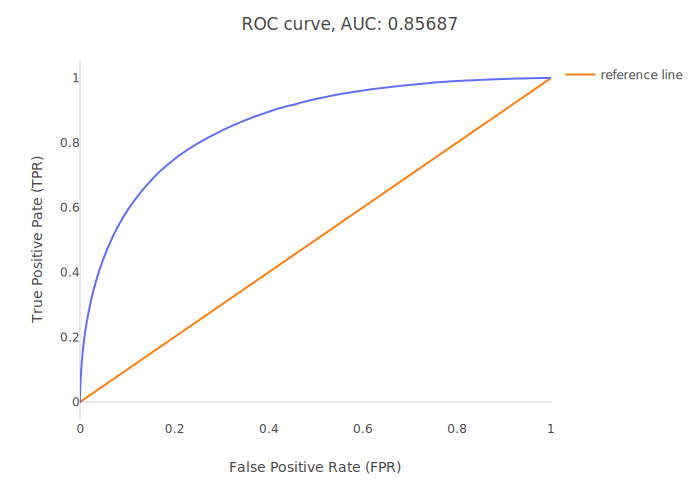

In [7]:
fig = px.line(roc_tab
              , x="FPR"
              , y="TPR")

fig.update_layout(title=f'ROC curve, AUC: {roc_auc:.5f}'
                  , xaxis_title='False Positive Rate (FPR)'
                  , yaxis_title='True Positive Pate (TPR)'
                  , template='none')

fig.add_trace(
    go.Scatter(x=roc_tab['FPR'], y=roc_tab['FPR'], name="reference line", line_shape='linear')
)

fig.update_xaxes(showgrid=False, zeroline=True, zerolinewidth=1, zerolinecolor='lightgray')
fig.update_yaxes(showgrid=False, zeroline=True, zerolinewidth=1, zerolinecolor='lightgray')

fig.show(renderer='svg')